# Bootstrapping

## Imports

In [1]:
import numpy as np

In [2]:
import scipy as sp
from scipy.interpolate import UnivariateSpline

In [3]:
import pandas as pd

In [4]:
import statsmodels.api as sm

In [5]:
import lmfit

In [6]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.ticker as ticker

## Preamble

In [7]:
plt.rc('font',   size=16)          # controls default text sizes
plt.rc('axes',   titlesize=20)     # fontsize of the axes title
plt.rc('axes',   labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=20)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=20)     # fontsize of the tick labels
plt.rc('legend', fontsize=18)      # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title

## Estimating the variance

Create the synthetic dataset:

In [8]:
rng = np.random.default_rng(1245927)                     # Set the seed for the random number generator
N = 50                                                   # Size of the dataset
x = rng.normal(10.0, 5.0, size=N)                        # Our observed dataset: mu=10, sigma=5

Compute the variance from the bootstrap sample:

In [9]:
M = 1000
z = rng.choice(x, (M, N), replace=True)                  # M bootstrapped datasets. Size: M x N.
theta = np.mean(z, axis=1)                               # The mean of each of our bootstrapped datasets
variance = np.var(theta, ddof=1)                         # ddof=1 means: divide by N-1 rather than N

print("Mean: ", np.mean(x))
print("Bootstrap variance: ", variance)
print("Bootstrap stdev: ", np.sqrt(variance))

Mean:  10.969344649379925
Bootstrap variance:  0.47964864161945986
Bootstrap stdev:  0.6925667055377842


Plot the original dataset:

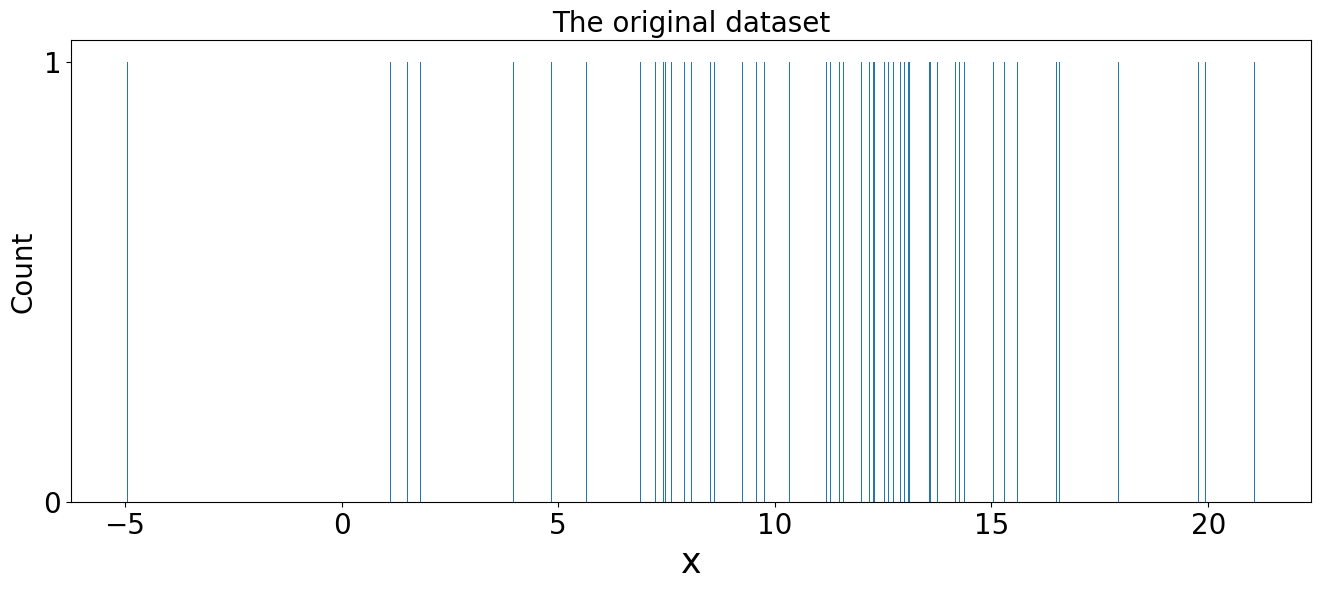

In [10]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
ax.hist(x, bins=900, rwidth=0.80)
ax.set_xlabel("x", fontsize=25)
ax.set_ylabel("Count")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("The original dataset")
plt.show()

Plot one of the replicated datasets:

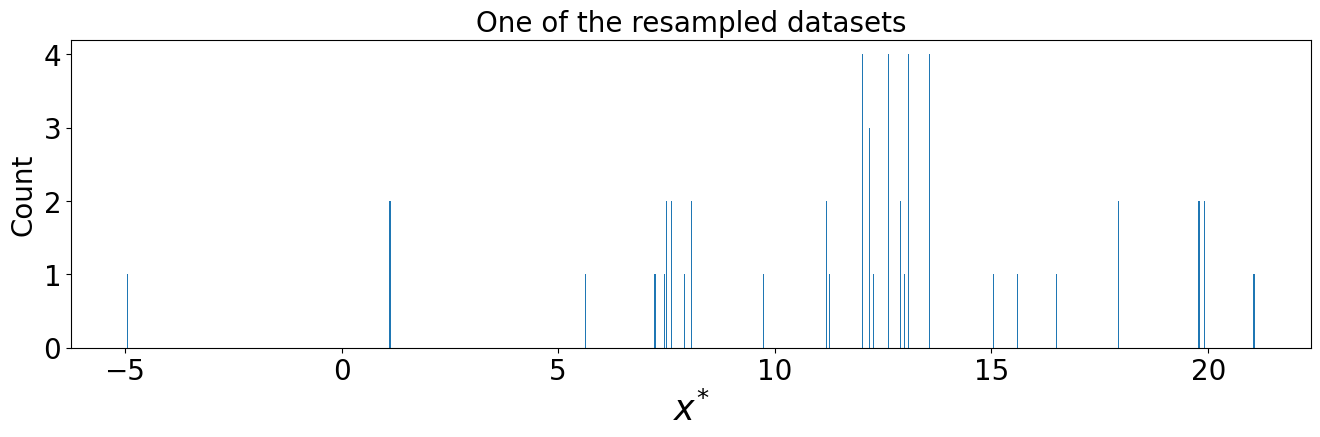

In [11]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
ax.hist(z[-2], bins=800, rwidth=0.80)
ax.set_xlabel(r"$x^{*}$", fontsize=25)
ax.set_ylabel("Count")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title("One of the resampled datasets")
plt.show()

Plot the bootstrap sample of mean values. It's the standard deviation of this sample that we will take as the uncertainty on the mean of our original sample.

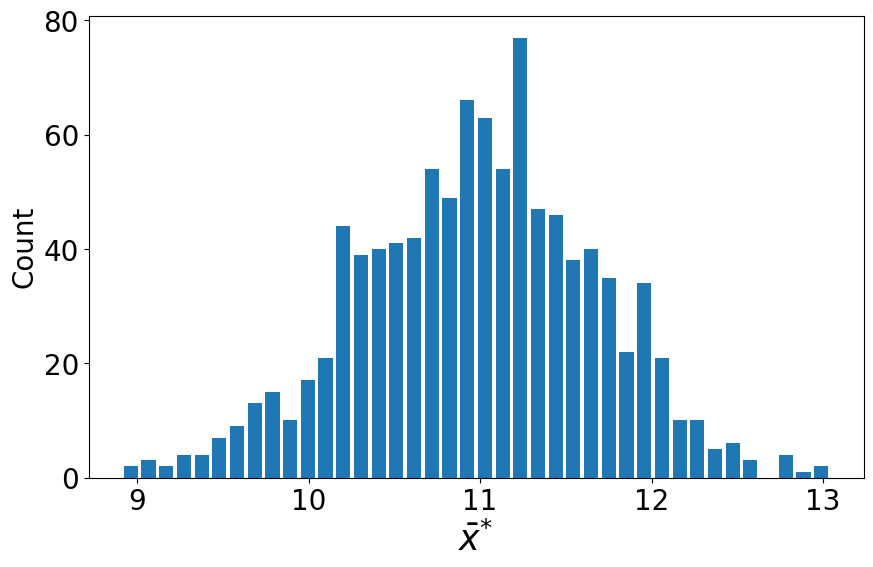

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(theta, bins=40, rwidth=0.80)
ax.set_xlabel(r"$\bar{x}^{*}$", fontsize=25)
ax.set_ylabel("Count")
plt.show()

***

## Estimating a confidence interval (CI) of the mean

The dataset:

In [13]:
N = 10
x = np.array([-2.41, 4.86, 6.06, 9.11, 10.20, 12.81, 13.17, 14.10, 15.77, 15.79])

In [14]:
print("Mean of the dataset: ", x.mean())

Mean of the dataset:  9.946000000000002


### Bootstrap percentile method

This method is using a non-parametric bootstrap approach.

In [15]:
rng = np.random.default_rng(12435927)
M = 1000
z = rng.choice(x, (M, N), replace=True)                                     # M bootstrapped datasets. Size: M x N.
theta = np.mean(z, axis=1)

quantiles = np.quantile(theta, [0.005, 0.025, 0.05, 0.95, 0.975, 0.995])
print("90% CI: ", quantiles[2], quantiles[3])
print("95% CI: ", quantiles[1], quantiles[4])                               # Theoretical values: 6.85, 13.05
print("99% CI: ", quantiles[0], quantiles[5])

90% CI:  7.053 12.60605
95% CI:  6.568975 13.017249999999999
99% CI:  4.91659 13.60634


These are called the bootstrap percentile interval.

As usual, always plot your bootstrap sample:

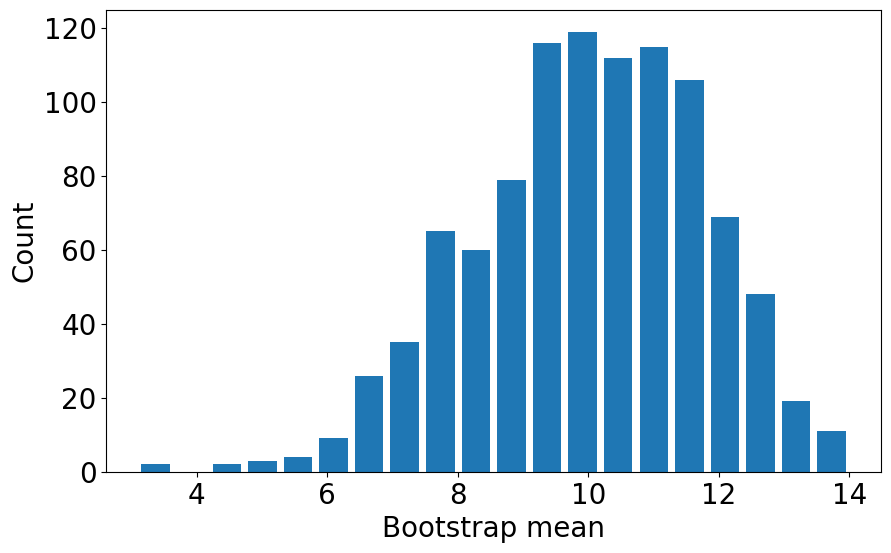

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(theta, bins=20, rwidth=0.80)
ax.set_xlabel("Bootstrap mean")
ax.set_ylabel("Count")
plt.show()

### Parametric bootstrap

In [17]:
rng = np.random.default_rng(12435927)
M = 2000
mu = np.mean(x)                                                     # The mean of our original dataset
sigma = np.std(x, ddof=1)                                           # The standard deviation of our original dataset
z = rng.normal(mu, sigma, size=(M, N))                              # M bootstrapped datasets from our Normal model.
theta = np.mean(z, axis=1)

quantiles = np.quantile(theta, [0.005, 0.025, 0.05, 0.95, 0.975, 0.995])
print("90% CI: ", quantiles[2], quantiles[3])
print("95% CI: ", quantiles[1], quantiles[4])                       # Theoretical values: 6.85, 13.05
print("99% CI: ", quantiles[0], quantiles[5])

90% CI:  7.018419670628357 12.843243892836025
95% CI:  6.5623651755369705 13.424178881141316
99% CI:  5.2009496897192795 14.29876460013262


Our bootstrap sample:

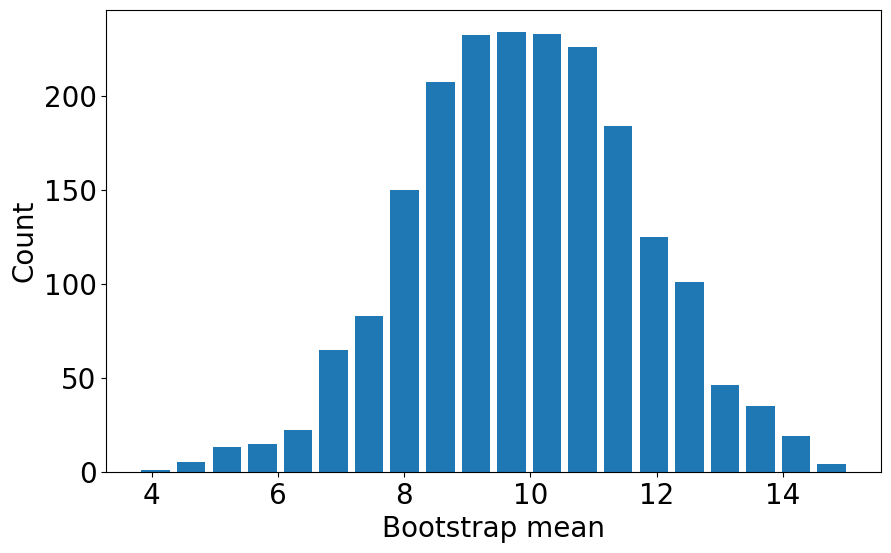

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(theta, bins=20, rwidth=0.80)
ax.set_xlabel("Bootstrap mean")
ax.set_ylabel("Count")
plt.show()

### Nested bootstrap with an asymptotic  pivot

In [19]:
rng = np.random.default_rng(12435927)

# Compute the mean 'mu' and the stdev 'sigma' using a bootstrap procedure

mu = np.mean(x)
M1 = 25
z = rng.choice(x, (M1, N), replace=True)                                    # M1 bootstrapped datasets. Size: M1 x N.
muStar = np.mean(z, axis=1)
sigma = np.std(muStar, ddof=1)
print('Estimated mean and its uncertainty for original dataset: ', mu, sigma)

# Compute the distribution of the pivot with a bootstrap procedure

M2 = 1000                                                        # A large number is needed for the 2.5% quantiles
z = rng.choice(x, (M2, N), replace=True)                         # M2 bootstrapped datasets. Size: M2 x N.
muStar = np.mean(z, axis=1)                                      # Mean of each of the replicated datasets
pivot = np.zeros(M2)                                             # Pivot for each of the replicated datasets
for m in range(M2):
    v = rng.choice(z[m,:], (M1, N), replace=True)                # Bootstrapping of a bootstrapped dataset: X**
    muStarStar = np.mean(v, axis=1)                              # Mean of all the double bootstrapped datasets
    sigmaStarStar = np.std(muStarStar, ddof=1)                   # Uncertainty on mu for one of the Star
    pivot[m] = (muStar[m] - mu)/sigmaStarStar

# Get the 95% quantiles of the pivot

t025, t975 = np.quantile(pivot, [0.025, 0.975])

# Compute the confidence interval of the mean

CIlower = mu - sigma * t975
CIupper = mu - sigma * t025

print("95% CI interval: ", CIlower, CIupper)

Estimated mean and its uncertainty for original dataset:  9.946000000000002 1.5720714604198711
95% CI interval:  4.34927856277878 13.007601781426942


Plot of our bootstrap sample of the pivot:

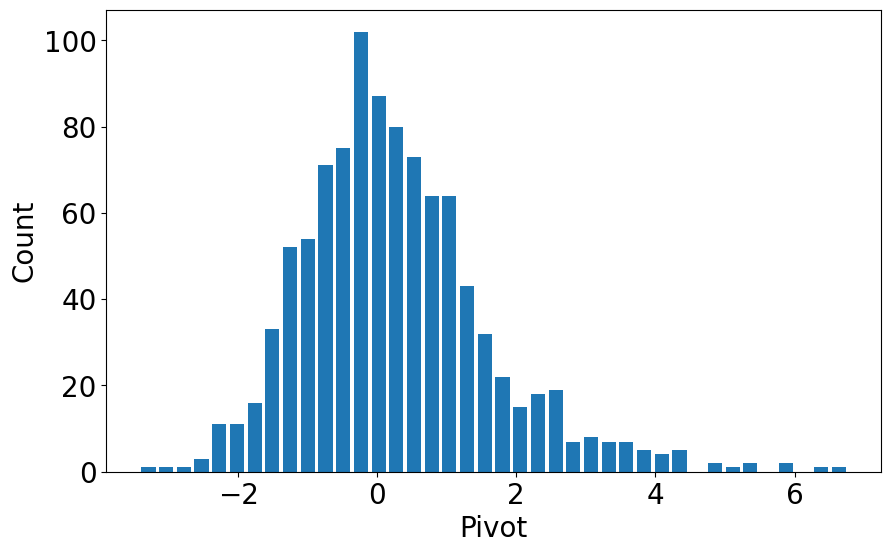

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(pivot, bins=40, rwidth=0.80)
ax.set_xlabel("Pivot")
ax.set_ylabel("Count")
plt.show()

***

## Confidence intervals and regions of regression coefficients in linear regression

Create the synthetic dataset

In [21]:
rng = np.random.default_rng(82)
N = 100
K = 2
x = np.linspace(0, 5, N)
noise = rng.normal(0.0, 1.2, N)
y = 2*x+x**2 + noise

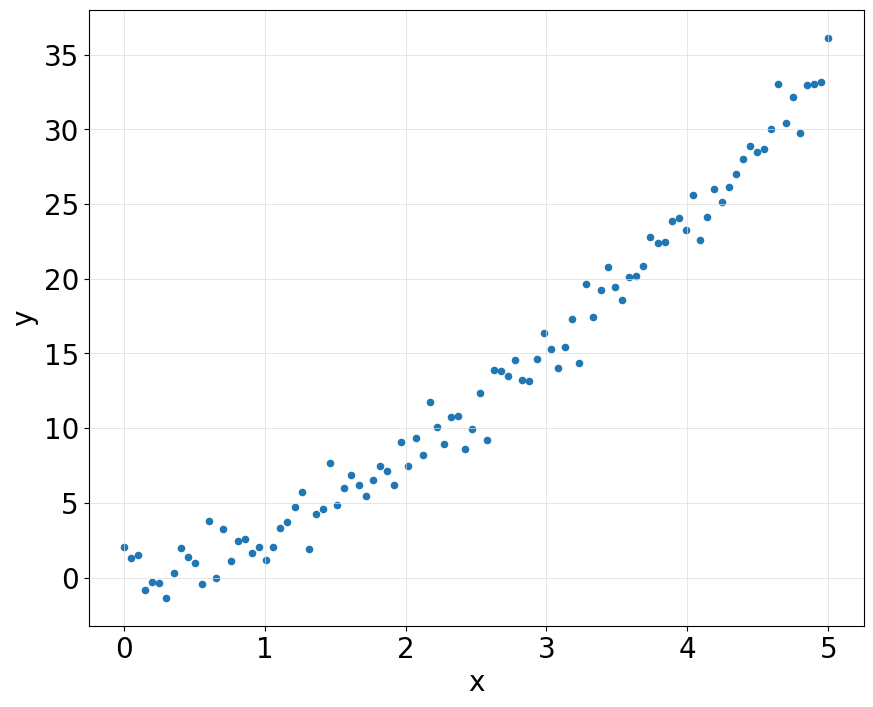

In [22]:
matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.scatter(x, y, s=20) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_facecolor('white')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Compute the design matrix, and fit the observations:

In [23]:
X = np.column_stack([x, x**2])
myFit = sm.OLS(y, X).fit()

In [24]:
myFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              9394.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                   1.10e-112
Time:                        23:54:46   Log-Likelihood:                         -161.41
No. Observations:                 100   AIC:                                      326.8
Df Residuals:                      98   BIC:                                      332.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1192      0.170     12.486      0.000       1.782       2.456
x2             0.9607      0.044     22.032      0.000       0.874       1.047
==============================================================================
Omnibus:                        0.446   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.800   Jarque-Bera (JB):                0.591
Skew:                           0.009   Prob(JB):                        0.744
Kurtosis:                       2.624   Cond. No.                         16.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

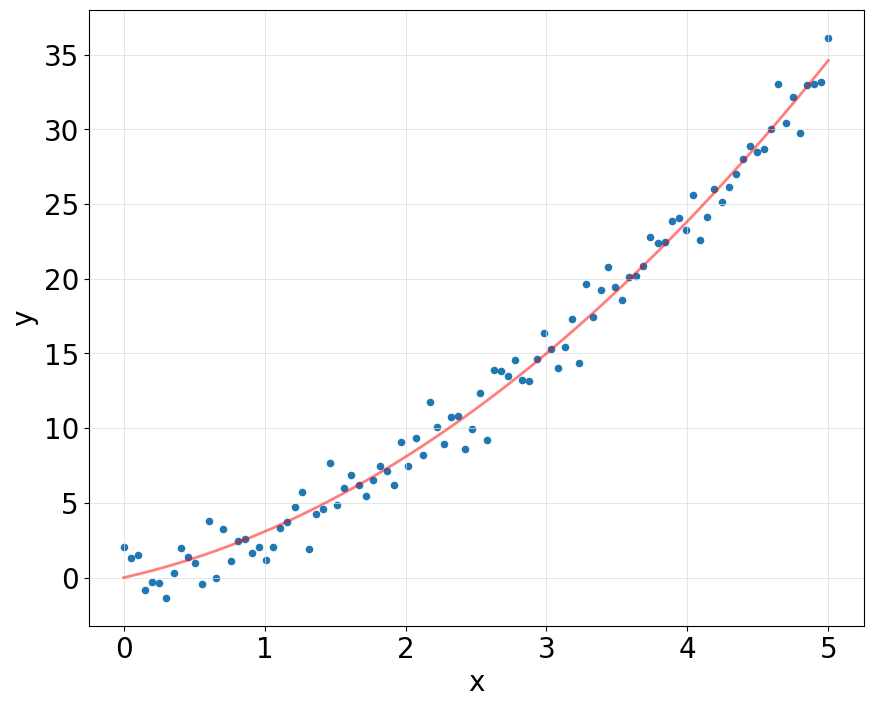

In [25]:
matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.scatter(x, y, s=20)
ax.plot(x, myFit.fittedvalues, color="red", linewidth=2, alpha=0.5) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_facecolor('white')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Our best fit parameters:

In [26]:
bestTheta1, bestTheta2 = myFit.params                 
stdErrorTheta1, stdErrorTheta2 = myFit.bse

print("theta1 = {0} +/- {1}".format(bestTheta1, stdErrorTheta1))
print("theta2 = {0} +/- {1}".format(bestTheta2, stdErrorTheta2))

theta1 = 2.1192087827784705 +/- 0.16972539082128993
theta2 = 0.9606915532673141 +/- 0.043603976471943244


Compute the 95% confidence interval assuming Gaussian noise:

In [27]:
alpha = 0.05
confIntervals = myFit.conf_int(alpha=alpha)

print("95% CI theta1: ", confIntervals[0])
print("95% CI theta2: ", confIntervals[1])

95% CI theta1:  [1.78239427 2.4560233 ]
95% CI theta2:  [0.87416088 1.04722223]


The cost (chi-square) function:

In [28]:
def S(theta1, theta2):
    cost = 0.0
    for n in range(len(x)):
        cost += (y[n] - theta1 * x[n] - theta2 * x[n]**2)**2 
    return cost

Make a grid and evaluate the cost function in this grid:

In [29]:
theta1 = np.linspace(1.0, 3.5, 500)
theta2 = np.linspace(0.7, 1.2, 500)
Theta1, Theta2 = np.meshgrid(theta1, theta2)
surface = S(Theta1, Theta2)
bestS = S(bestTheta1, bestTheta2)

### Percentile method using paired bootstrap

In [30]:
rng = np.random.default_rng(125927)                     # Set the seed for the random number generator
M = 8000
idx = rng.choice(np.arange(len(x)), (M,N), replace=True)
theta1Boot = np.zeros(M)
theta2Boot = np.zeros(M)
for m in range(M):
    Xboot = X[idx[m]]
    yboot = y[idx[m]]
    myFit = sm.OLS(yboot, Xboot).fit()
    theta1Boot[m] = myFit.params[0]
    theta2Boot[m] = myFit.params[1]

In [31]:
theta1BootLower, theta1BootUpper = np.quantile(theta1Boot, [alpha/2, 1-alpha/2])
theta2BootLower, theta2BootUpper = np.quantile(theta2Boot, [alpha/2, 1-alpha/2])

print(theta1BootLower, theta1BootUpper)
print(theta2BootLower, theta2BootUpper)

1.7915817236691904 2.465061082972878
0.8743098766582312 1.0449141558638202


Always check the boostrap samples to ensure that you have reliably sampled wings to compute the rather extreme quantiles. 

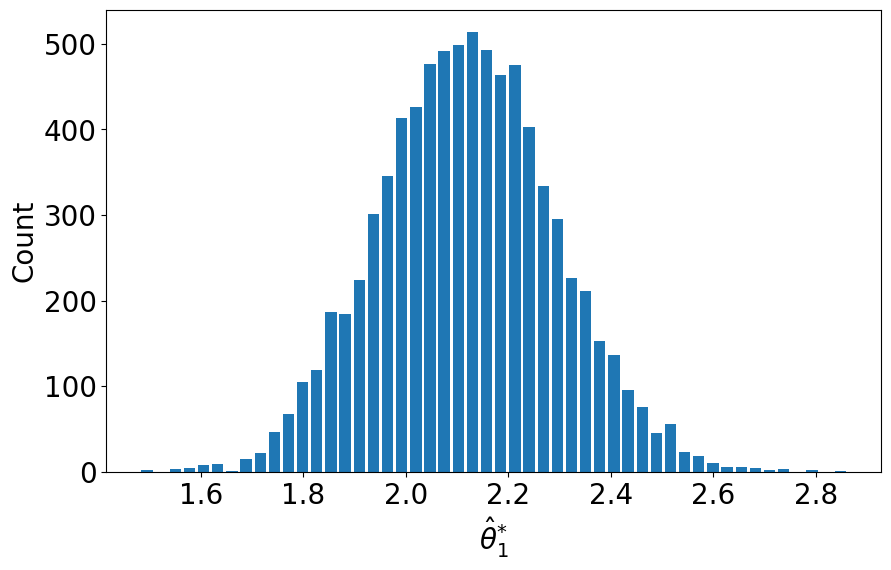

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(theta1Boot, bins=50, rwidth=0.80)
ax.set_xlabel(r"$\hat{\theta}_1^{*}$")
ax.set_ylabel("Count")
plt.show()

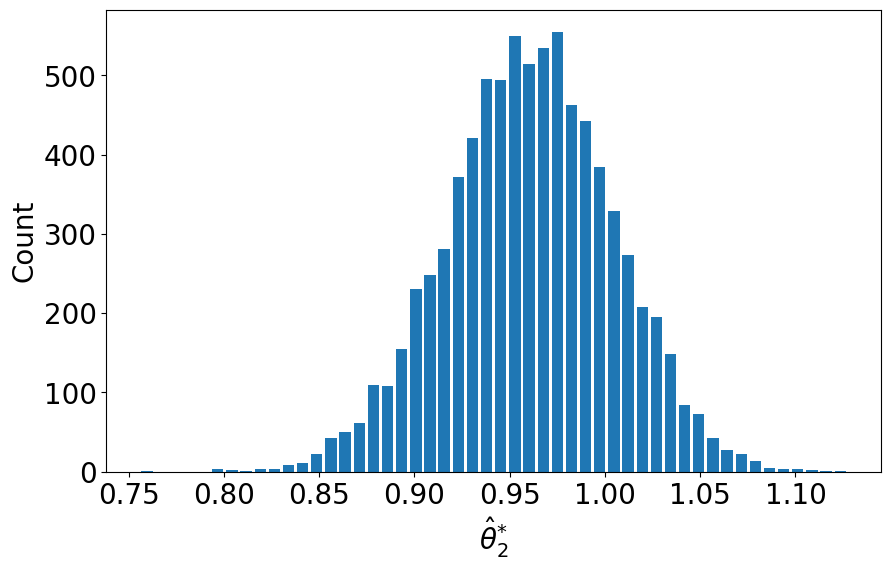

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.hist(theta2Boot, bins=50, rwidth=0.80)
ax.set_xlabel(r"$\hat{\theta}_2^{*}$")
ax.set_ylabel("Count")
plt.show()

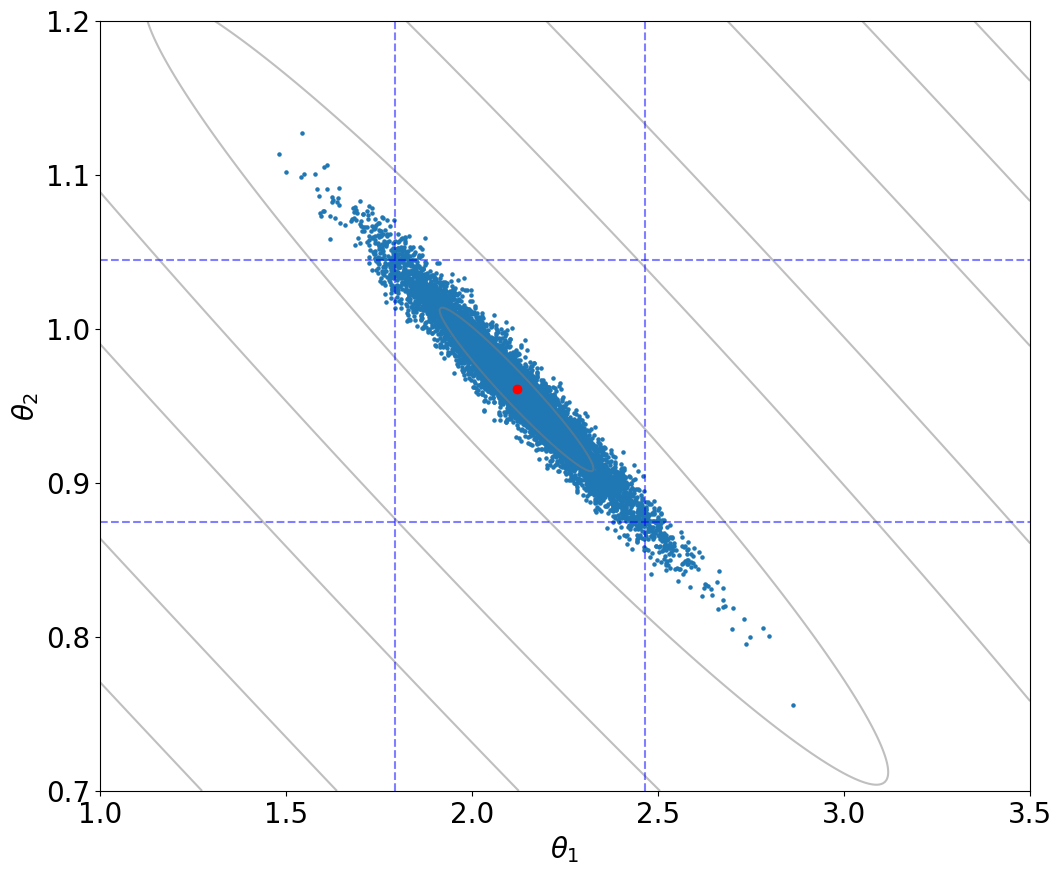

In [34]:
matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1,1, figsize=(12,10))

# Contours of the cost function at a few selected levels

levels = [150, 200, 500, 1000, 2000, 3000, 4000]
contours = ax.contour(Theta1, Theta2, surface, levels=levels, colors="gray", alpha=0.5)

# Our best estimate

ax.scatter(theta1Boot, theta2Boot, s=5)

# Our bootstrap sample of theta1 and theta2

ax.scatter([bestTheta1], [bestTheta2], c="red")

# The individual confidence intervals 

xmin, xmax = 1.0, 3.5
ymin, ymax = 0.7, 1.2
plt.hlines([theta2BootLower, theta2BootUpper], xmin, xmax, color="blue", linestyle="dashed", alpha=0.5)
plt.vlines([theta1BootLower, theta1BootUpper], ymin, ymax, color="blue", linestyle="dashed", alpha=0.5)


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$\theta_1$', fontsize=20)
ax.set_ylabel(r'$\theta_2$', fontsize=20)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()

***

## Confidence intervals and regions of regression coefficients in nonlinear regression

In [35]:
def myFunc(x, theta1, theta2):
    return theta1 * (1-np.exp(-theta2*x))

Create a synthetic noisy dataset

In [36]:
rng = np.random.default_rng(92)
N = 50
x = rng.uniform(0.0, 4.6, N)
y = myFunc(x, 1.0, 1.0) + rng.normal(0.0, 0.05, N)

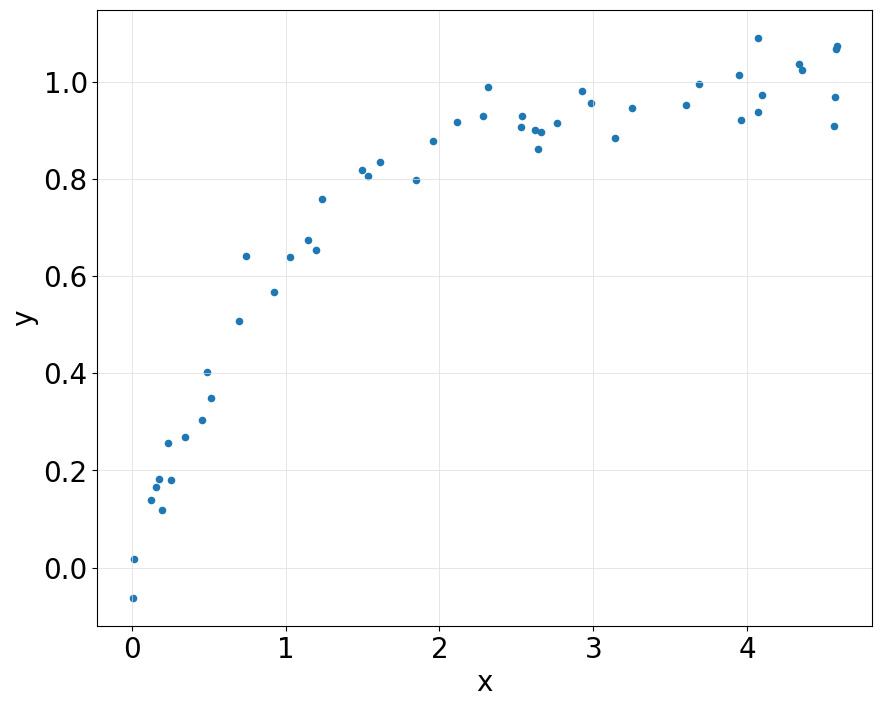

In [37]:
matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.scatter(x, y, s=20) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_facecolor('white')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Fit the model to the data:

In [38]:
myModel = lmfit.Model(myFunc)
myModel.set_param_hint('theta1', value=1)
myModel.set_param_hint('theta2', value=1)

In [39]:
myFit = myModel.fit(y, x=x)

In [40]:
myFit.params

name,value,standard error,relative error,initial value,min,max,vary
theta1,1.00755000,0.01351581,(1.34%),1,-inf,inf,True
theta2,0.98926836,0.04699712,(4.75%),1,-inf,inf,True


In [41]:
xvalues = np.linspace(x.min(), x.max(), 100)
fittedValues = myModel.eval(x=xvalues, params=myFit.params)

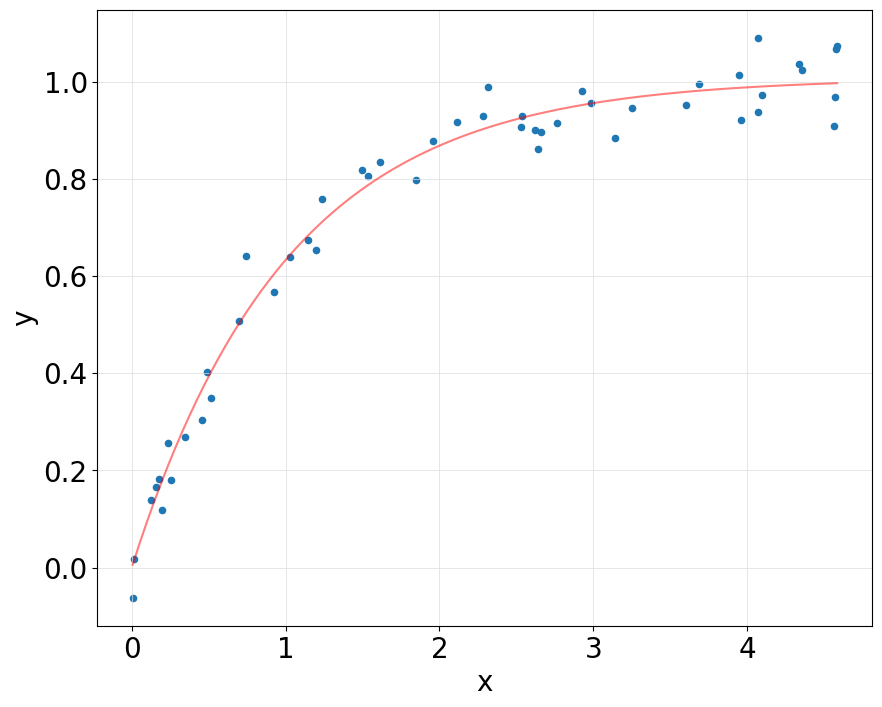

In [42]:
matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.scatter(x, y, s=20) 
ax.plot(xvalues, fittedValues, c="red", alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_facecolor('white')
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

Create a dense mesh, and compute the cost function in this mesh. All this info will be used later in the plot.

In [43]:
def S(theta1, theta2):
    cost = 0.0
    for n in range(len(x)):
        cost += (y[n] - myFunc(x[n], theta1, theta2))**2 
    return cost

In [44]:
theta1 = np.linspace(0.0, 8.0, 500)
theta2 = np.linspace(0.0, 3.0, 500)
Theta1, Theta2 = np.meshgrid(theta1, theta2)
surface = S(Theta1, Theta2)

In [45]:
bestTheta1 = myFit.best_values['theta1']
bestTheta2 = myFit.best_values['theta2']
bestS = S(bestTheta1, bestTheta2)
print("best (theta1, theta2) = ", bestTheta1, bestTheta2)
print("S(beta theta) = ", bestS)

best (theta1, theta2) =  1.007549996110771 0.9892683555335225
S(beta theta) =  0.11197411135346179


Compute the theoretical contour level that corresponds to a 95% confidence level:

In [46]:
K = 2
alpha = 0.05
Fdistrib = sp.stats.f(K, N-K)
contourLevel95 = bestS * (1+K/(N-K)*Fdistrib.ppf(1-alpha))
print(contourLevel95)

0.12686073043728646


#### Compute the uncertainty on theta1 and theta2 using residual bootstrapping:

In [47]:
rng = np.random.default_rng(1450027)                     # Set the seed for the random number generator
M = 3000

myFit = myModel.fit(y, x=x)
yfitted = myFit.eval(myFit.params)
residuals = myFit.residual

z = yfitted + rng.choice(residuals, (M,N), replace=True)
theta1Boot = np.zeros(M)
theta2Boot = np.zeros(M)
for m in range(M):
    myFitBoot = myModel.fit(z[m], x=x)
    theta1Boot[m] = myFitBoot.params['theta1'].value
    theta2Boot[m] = myFitBoot.params['theta2'].value
    
stdErrorTheta1 = np.std(theta1Boot, ddof=1)
stdErrorTheta2 = np.std(theta2Boot, ddof=1)
print("Bootstrapped sigma theta_1: ", stdErrorTheta1)
print("Bootstrapped sigma theta_2: ", stdErrorTheta2)

Bootstrapped sigma theta_1:  0.013559515496244122
Bootstrapped sigma theta_2:  0.046604955076753475


Always plot the bootstrap samples to see if the histogram looks fairly smooth.

Text(0, 0.5, 'Count')

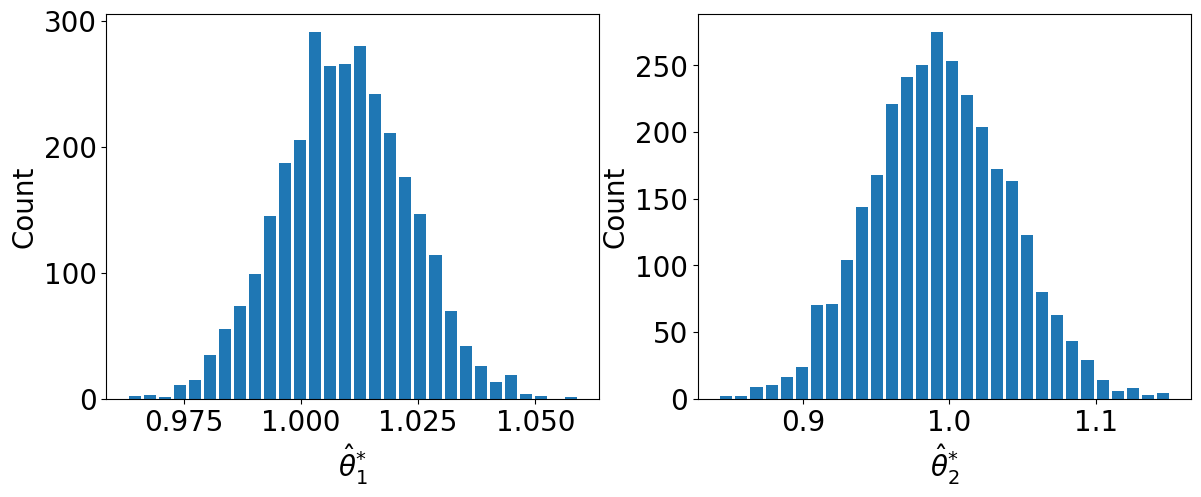

In [48]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].hist(theta1Boot, bins=30, rwidth=0.80)
axes[0].set_xlabel(r"$\hat{\theta}^{*}_1$")
axes[0].set_ylabel("Count")

axes[1].hist(theta2Boot, bins=30, rwidth=0.80)
axes[1].set_xlabel(r"$\hat{\theta}^{*}_2$")
axes[1].set_ylabel("Count")

### Confidence intervals using the percentile method using paired bootstrap

In [49]:
rng = np.random.default_rng(125927)                     # Set the seed for the random number generator

M = 5000
idx = rng.choice(np.arange(len(x)), (M,N), replace=True)
theta1Boot = np.zeros(M)
theta2Boot = np.zeros(M)
for m in range(M):
    xboot = x[idx[m]]
    yboot = y[idx[m]]
    myFit = myModel.fit(yboot, x=xboot)
    theta1Boot[m] = myFit.params['theta1'].value
    theta2Boot[m] = myFit.params['theta2'].value

In [50]:
theta1BootLower, theta1BootUpper = np.quantile(theta1Boot, [alpha/2, 1-alpha/2])
theta2BootLower, theta2BootUpper = np.quantile(theta2Boot, [alpha/2, 1-alpha/2])

print(theta1BootLower, theta1BootUpper)
print(theta2BootLower, theta2BootUpper)

0.978243196926706 1.0382327964515836
0.899406571890056 1.0968491999443453


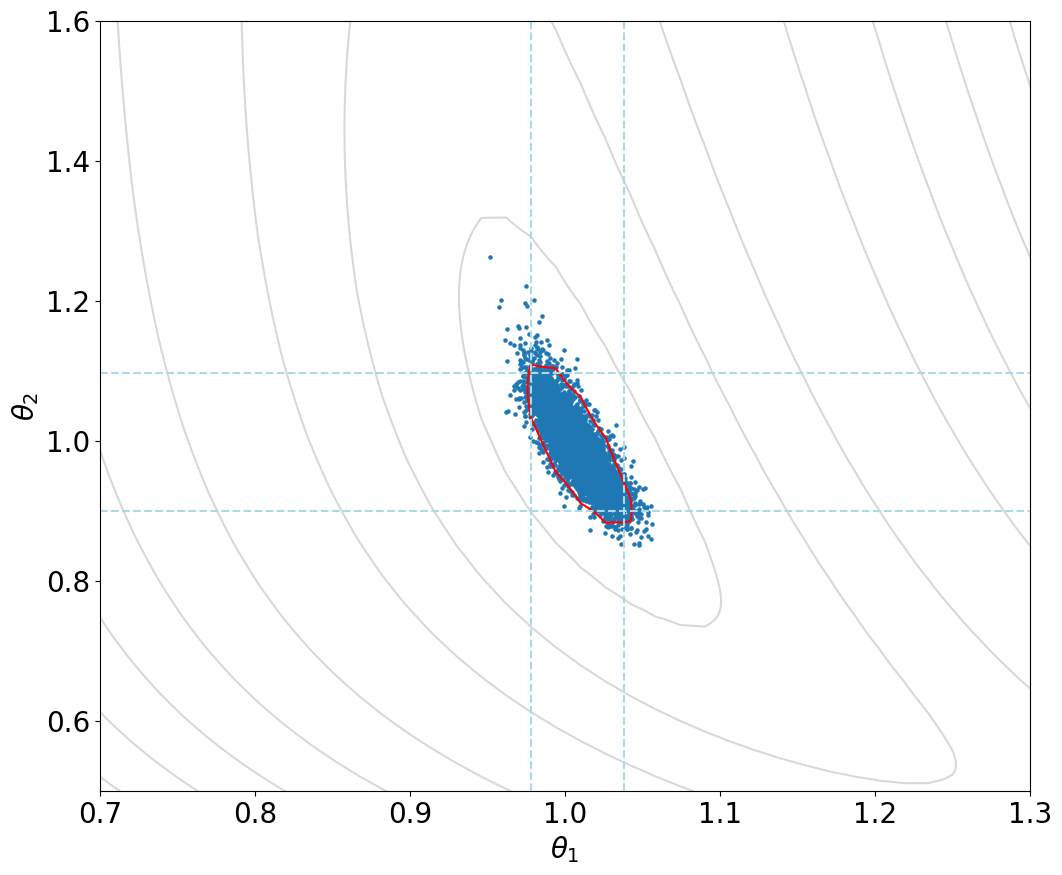

In [51]:
matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1,1, figsize=(12,10))

# Contour levels of the cost function (chi-square)

levels = [0.075, 0.2, 0.5, 1., 2., 3., 4., 5., 6., 7., 10]
contours = ax.contour(Theta1, Theta2, surface, levels=levels, colors="gray", alpha=0.3)
contours = ax.contour(Theta1, Theta2, surface, levels=[contourLevel95], colors="red")

# The bootstrap sample

plt.scatter(theta1Boot, theta2Boot, marker='o', s=5)

# Individual confidence intervals

xmin, xmax = 0.7, 1.3
ymin, ymax = 0.5, 1.6
plt.hlines([theta2BootLower, theta2BootUpper], xmin, xmax, color="lightblue", linestyle="dashed")
plt.vlines([theta1BootLower, theta1BootUpper], ymin, ymax, color="lightblue", linestyle="dashed")


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$\theta_1$', fontsize=20)
ax.set_ylabel(r'$\theta_2$', fontsize=20)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

### Percentile method using residual bootstrapping

Here the x-values are fixed.

In [52]:
rng = np.random.default_rng(1245927)                     # Set the seed for the random number generator
M = 5000

myFit = myModel.fit(y, x=x)
yfitted = myFit.eval(myFit.params)
residuals = myFit.residual

z = yfitted + rng.choice(residuals, (M,N), replace=True)
theta1Boot = np.zeros(M)
theta2Boot = np.zeros(M)
for m in range(M):
    myFitBoot = myModel.fit(z[m], x=x)
    theta1Boot[m] = myFitBoot.params['theta1'].value
    theta2Boot[m] = myFitBoot.params['theta2'].value

In [53]:
theta1BootLower, theta1BootUpper = np.quantile(theta1Boot, [alpha/2, 1-alpha/2])
theta2BootLower, theta2BootUpper = np.quantile(theta2Boot, [alpha/2, 1-alpha/2])

print(theta1BootLower, theta1BootUpper)
print(theta2BootLower, theta2BootUpper)

0.9835246587353141 1.0353283542523708
0.9065026789641859 1.087551887413461


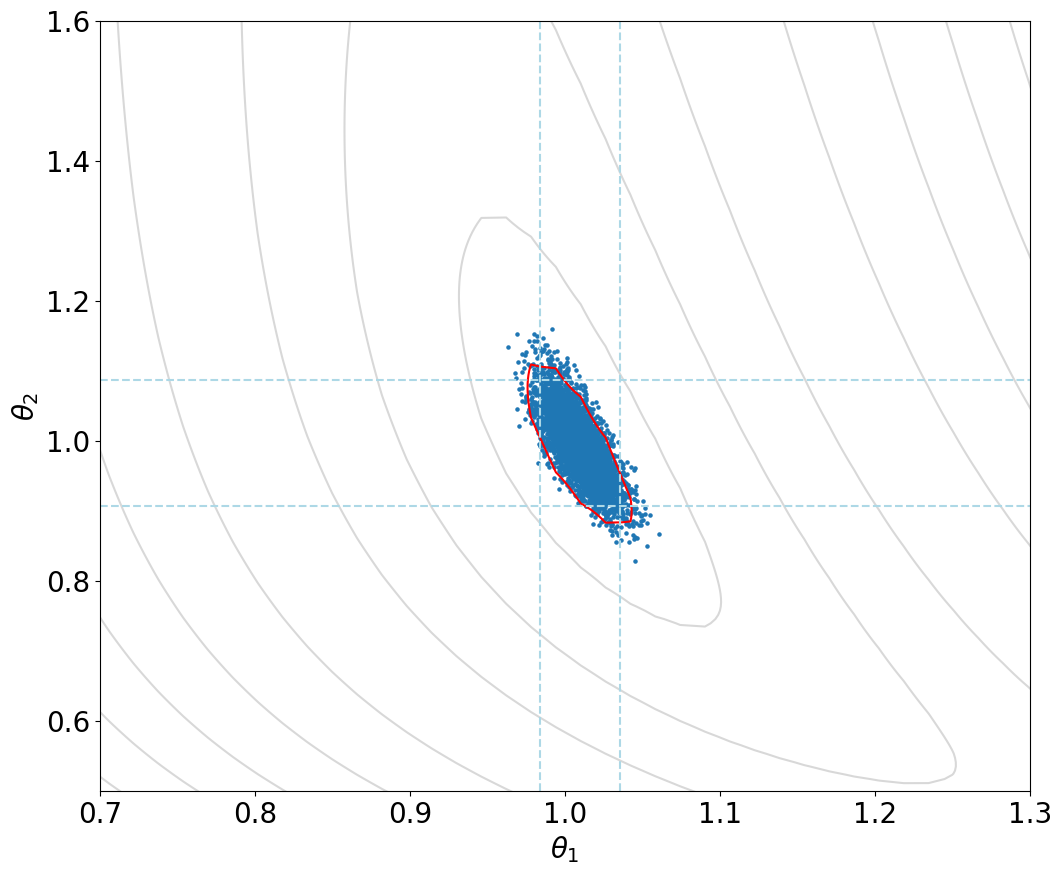

In [54]:
matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1,1, figsize=(12,10))

# Contour levels of the cost function

levels = [0.075, 0.2, 0.5, 1., 2., 3., 4., 5., 6., 7., 10]
contours = ax.contour(Theta1, Theta2, surface, levels=levels, colors="gray", alpha=0.3)
contours = ax.contour(Theta1, Theta2, surface, levels=[contourLevel95], colors="red")

# The bootstrap sample

plt.scatter(theta1Boot, theta2Boot, marker='o', s=5)

# Individual confidence intervals

xmin, xmax = 0.7, 1.3
ymin, ymax = 0.5, 1.6
plt.hlines([theta2BootLower, theta2BootUpper], xmin, xmax, color="lightblue", linestyle="dashed")
plt.vlines([theta1BootLower, theta1BootUpper], ymin, ymax, color="lightblue", linestyle="dashed")

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$\theta_1$', fontsize=20)
ax.set_ylabel(r'$\theta_2$', fontsize=20)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

### Studentized bootstrap confidence interval

A lot **slower** than the previous methods, but more stable. Launch this, then drink a large cup of tea. Or two.

In [55]:
rng = np.random.default_rng(12435927)

myModel = lmfit.Model(myFunc)
myModel.set_param_hint('theta1', value=1)
myModel.set_param_hint('theta2', value=1)
myFit = myModel.fit(y, x=x)
yfitted = myFit.eval(myFit.params)
residuals = myFit.residual

M1 = 5000
pivotTheta1 = np.zeros(M1)
pivotTheta2 = np.zeros(M1)

theta1Boot = np.zeros(M1)
theta2Boot = np.zeros(M1)
stdTheta1Boot = np.zeros(M1)
stdTheta2Boot = np.zeros(M1)

for m in range(M1):
    if m%500 == 0: print(m)
    residualsBoot = rng.choice(residuals, N, replace=True)
    z = yfitted + residualsBoot
    myFitBoot = myModel.fit(z, x=x)
    theta1Boot[m] = myFitBoot.params['theta1'].value
    theta2Boot[m] = myFitBoot.params['theta2'].value

    M2 = 500
    theta1Star = np.zeros(M2)
    theta2Star = np.zeros(M2)
    for j in range(M2):
        v = yfitted + rng.choice(residualsBoot, N, replace=True)       # Bootstrapping of a bootstrapped dataset: X**
        myFitStar = myModel.fit(v, x=x)
        theta1Star[j] = myFitStar.params['theta1'].value
        theta2Star[j] = myFitStar.params['theta2'].value
    
    stdTheta1Boot[m] = np.std(theta1Star, ddof=1)
    stdTheta2Boot[m] = np.std(theta2Star, ddof=1)
    pivotTheta1[m] = (theta1Boot[m] - bestTheta1) / stdTheta1Boot[m]
    pivotTheta2[m] = (theta2Boot[m] - bestTheta2) / stdTheta2Boot[m]
    
    
pivotTheta1LowerQuantile, pivotTheta1UpperQuantile = np.quantile(pivotTheta1, [alpha/2, 1-alpha/2])
pivotTheta2LowerQuantile, pivotTheta2UpperQuantile = np.quantile(pivotTheta2, [alpha/2, 1-alpha/2])

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [56]:
print(pivotTheta1LowerQuantile, pivotTheta1UpperQuantile)
print(pivotTheta2LowerQuantile, pivotTheta2UpperQuantile)

-1.755257828929858 2.1776763685789273
-1.8359106137018135 2.128139490296413


In [57]:
theta1BootLower = bestTheta1 - stdErrorTheta1 * pivotTheta1UpperQuantile
theta1BootUpper = bestTheta1 - stdErrorTheta1 * pivotTheta1LowerQuantile
theta2BootLower = bestTheta2 - stdErrorTheta2 * pivotTheta2UpperQuantile
theta2BootUpper = bestTheta2 - stdErrorTheta2 * pivotTheta2LowerQuantile

print("theta1: ", theta1BootLower, theta1BootUpper)
print("theta2: ", theta2BootLower, theta2BootUpper)

theta1:  0.9780217596452204 1.0313504418420492
theta2:  0.8900865101911932 1.0748308872100305


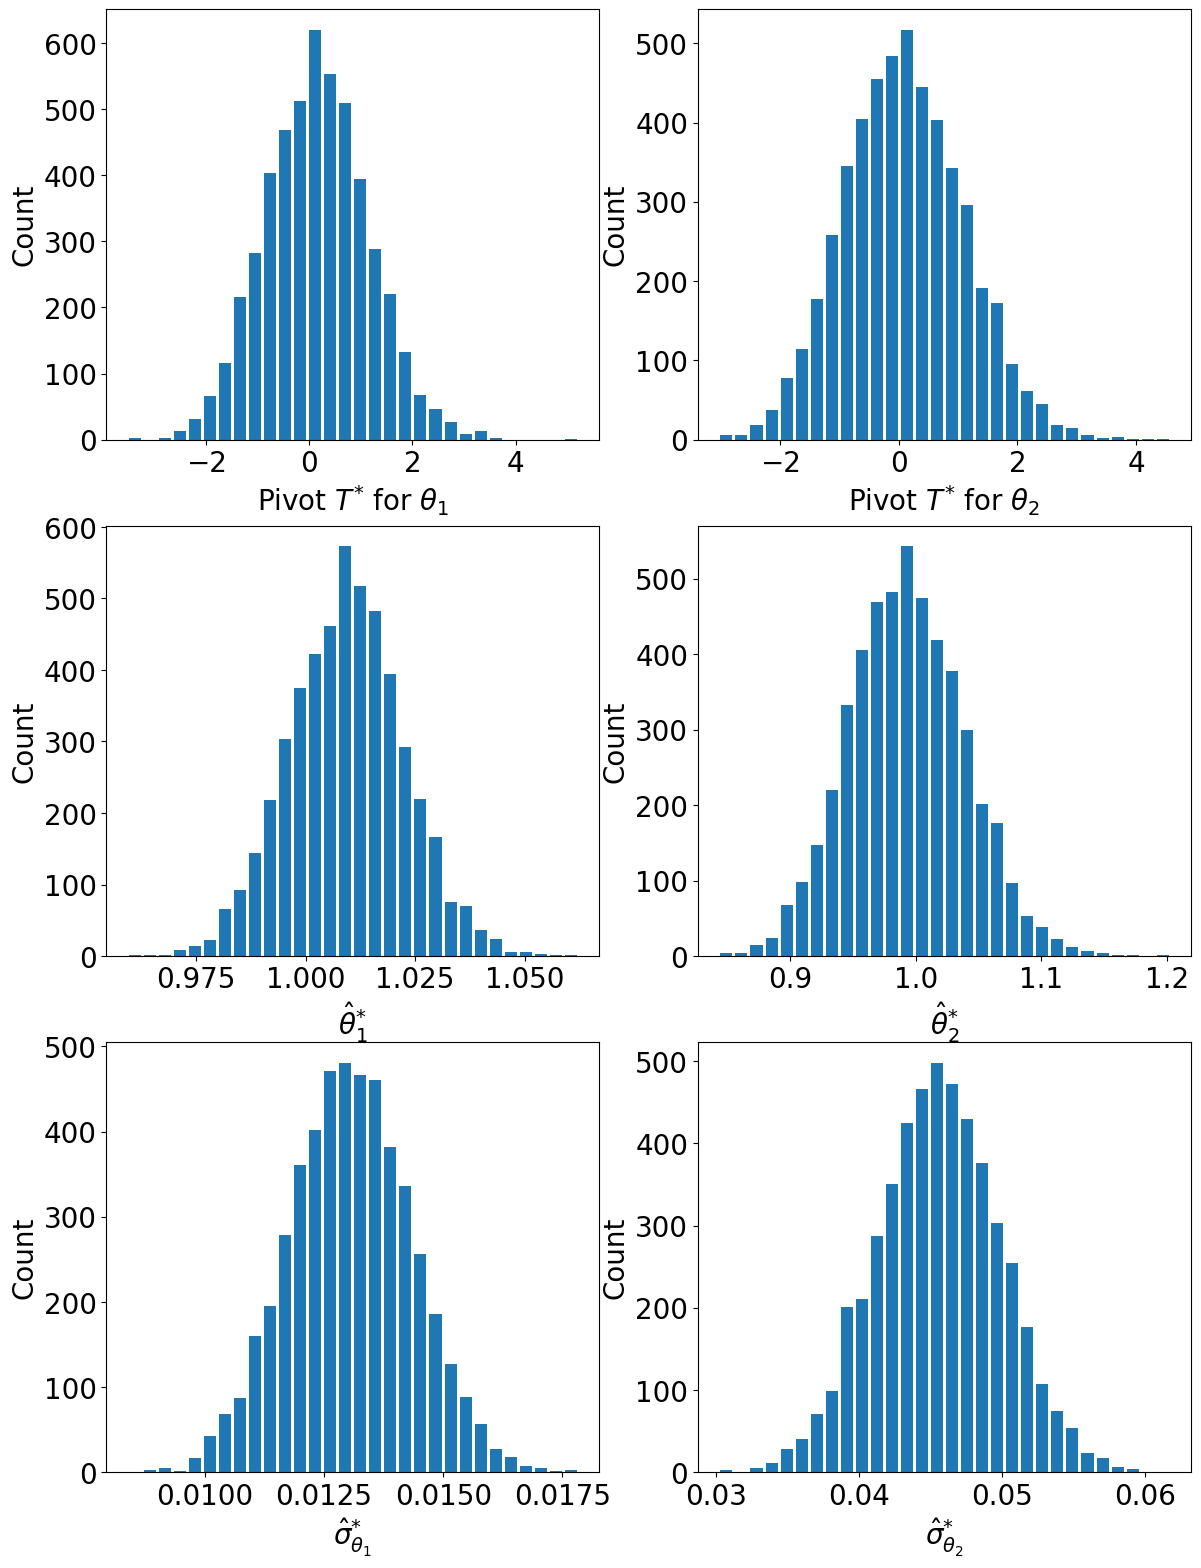

In [58]:
fig, axes = plt.subplots(3,2, figsize=(14,19))
axes[0,0].hist(pivotTheta1, bins=30, rwidth=0.80)
axes[0,0].set_xlabel(r"Pivot $T^{*}$ for $\theta_1$")
axes[0,0].set_ylabel("Count")

axes[0,1].hist(pivotTheta2, bins=30, rwidth=0.80)
axes[0,1].set_xlabel(r"Pivot $T^{*}$ for $\theta_2$")
axes[0,1].set_ylabel("Count")

axes[1,0].hist(theta1Boot, bins=30, rwidth=0.80)
axes[1,0].set_xlabel(r"$\hat{\theta}_1^{*}$")
axes[1,0].set_ylabel("Count")

axes[1,1].hist(theta2Boot, bins=30, rwidth=0.80)
axes[1,1].set_xlabel(r"$\hat{\theta}_2^{*}$")
axes[1,1].set_ylabel("Count")

axes[2,0].hist(stdTheta1Boot, bins=30, rwidth=0.80)
axes[2,0].set_xlabel(r"$\hat{\sigma}^{*}_{\theta_1}$")
axes[2,0].set_ylabel("Count")

axes[2,1].hist(stdTheta2Boot, bins=30, rwidth=0.80)
axes[2,1].set_xlabel(r"$\hat{\sigma}^{*}_{\theta_2}$")
axes[2,1].set_ylabel("Count")

plt.show()

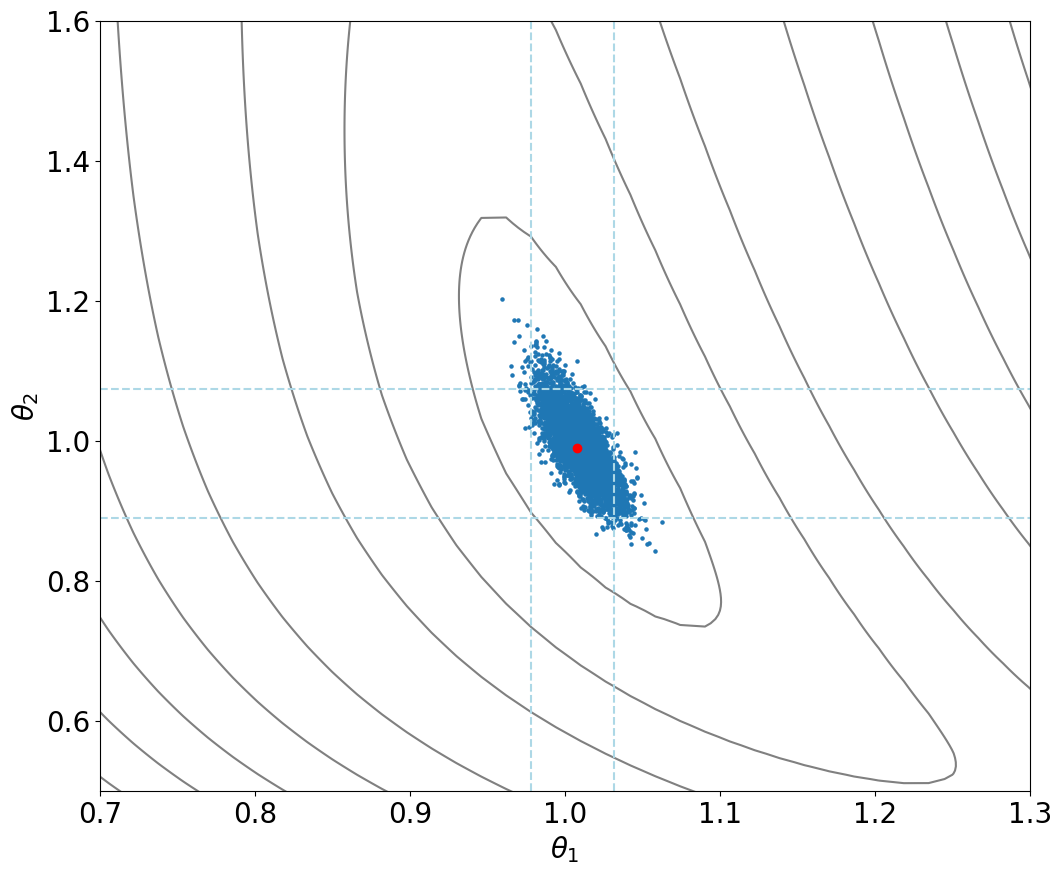

In [59]:
matplotlib.rcParams['text.usetex'] = False
fig, ax = plt.subplots(1,1, figsize=(12,10))

levels = [0.075, 0.2, 0.5, 1., 2., 3., 4., 5., 6., 7., 10]
contours = ax.contour(Theta1, Theta2, surface, levels=levels, colors="gray")

ax.scatter(theta1Boot, theta2Boot, marker='o', s=5)
ax.scatter([bestTheta1], [bestTheta2], c="red")

xmin, xmax = 0.7, 1.3
ymin, ymax = 0.5, 1.6
plt.hlines([theta2BootLower, theta2BootUpper], xmin, xmax, color="lightblue", linestyle="dashed")
plt.vlines([theta1BootLower, theta1BootUpper], ymin, ymax, color="lightblue", linestyle="dashed")

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$\theta_1$', fontsize=20)
ax.set_ylabel(r'$\theta_2$', fontsize=20)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

***